# Model inspection

We will explore dimensionality reduction techniques for inspecting the feature representations of different models. So far, we have primarily focused on performance comparisons of different models trained for specific tasks such image classification or semantic segmentation. Model inspection can be provide insights about the characteristics of the learned representations.

**Objective:** Use dimensionality reduction techniques to visualise feature representations of deep convolutional neural networks.

In [71]:
# On Google Colab uncomment the following line to install PyTorch Lightning
# ! pip install lightning

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from torchmetrics.functional import accuracy
from sklearn import decomposition
from sklearn.manifold import TSNE

## Data

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling the MNIST dataset.

In [73]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = './data', batch_size: int = 32, num_workers: int = 4, transform = transforms.ToTensor()):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform        

        self.test_set = MNIST(self.data_dir, train=False, transform=self.transform, download=True)
        dev_set = MNIST(self.data_dir, train=True, transform=self.transform, download=True)
        self.train_set, self.val_set = random_split(dev_set, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

## Model

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

In [74]:
class ImageClassifier(LightningModule):
    def __init__(self, input_dim: tuple[int, int] = (28,28), output_dim: int = 10, learning_rate: float = 0.001):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # LeNet
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )        
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, self.output_dim)
            )

    def forward(self, x):
        # first pass x through the conv layers
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        # then pass linearised x through the fully connected layers
        return self.fc(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def process_batch(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)        
        acc = accuracy(preds, y, task='multiclass', num_classes=self.output_dim)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch[0][0:16, ...], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)

## Load pre-trained model

Let's start by loading the LeNet-like model previously trained for MNIST image classification.

**Task:** Add the path to your pre-trained MNIST classification model.

In [75]:
seed_everything(42, workers=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = MNISTDataModule(data_dir='./data', batch_size=32)

#model_dir = '<path_to_model_checkpoint>' # for example: './lightning_logs/classification/mnist-lenet/version_0/checkpoints/epoch=5-step=10314.ckpt'
model_dir = '/home/eder/Documents/Uni/MLImaging/TutSolutions/lightning_logs/classification/mnist-lenet/version_0/checkpoints/epoch=5-step=10314.ckpt'
model = ImageClassifier.load_from_checkpoint(model_dir, input_dim=(28,28), output_dim=10)

trainer = Trainer() # dummy trainer for running test() on the loaded model

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Testing

Evaluate the pre-trained model on the test data and confirm the classification accuracy.

In [76]:
trainer.test(model=model, datamodule=data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9884999990463257
        test_loss          0.035691097378730774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.035691097378730774, 'test_acc': 0.9884999990463257}]

## Extract feature embeddings

To extract the feature representations (also called embeddings) for test images, we need to modify the model. We want to obtain the feature vectors coming out of the convolutional part which would normally be passed on to the classification head (typically one or more fully connected layers) to make final predictions.

In the modified model below (derived from the original model), we already modified the test step to collate feature embeddings in a list.

**Task:** Implement the `get_embedding` function which should return the feature embeddings for a batch of test images.

In [77]:
class ImageClassifierEmbeddings(ImageClassifier):
    def __init__(self, input_dim: tuple[int, int] = (28,28), output_dim: int = 10, learning_rate: float = 0.001):
        super().__init__(input_dim, output_dim, learning_rate)       
        self.embeddings = [] # list where we still store the embeddings

    def get_embedding(self, batch):
        x, _ = batch
        #x = x.to(device)
        emb = self.conv(x)
        emb = emb.view(emb.size(0), -1)
        return emb
    
    def on_test_start(self):
        self.embeddings = [] # clear the list of embeddings at the start of testing

    def test_step(self, batch, batch_idx):
        emb = self.get_embedding(batch)
        self.embeddings.append(emb)

With this modified model we can now run the test routine again. After some reformatting and data conversion, we obtain a 2D array of stacked feature vectors (one per test image).

In [78]:
model_modified = ImageClassifierEmbeddings.load_from_checkpoint(model_dir, input_dim=(28,28), output_dim=10)
trainer.test(model=model_modified, datamodule=data)
embeddings = torch.cat(model_modified.embeddings, dim=0).cpu().numpy()

print(embeddings.shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

(10000, 256)


## Dimensionality reduction

For the LeNet-like CNN above, we obtain a 256-dimensional feature vector per MNIST image, as the last convolutional layer outputs 16 feature maps of size 4 x 4.

In order to visualise and inspect these high-dimensional features, we can apply dimensionality reduction techniques such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

We first create a pandas dataframe that we will use later for ease of visualisation.

In [79]:
labels = np.array([data.test_set[i][1] for i in range(0,len(data.test_set))]).astype(np.uint8)
df = pd.DataFrame(labels, columns=['class_label'])

### Principal Component Analysis

We use the PCA implementation of scikit-learn. Settging `n_components=0.95` will give us a PCA embedding that preserves 95% of the variance of the input features.

In [80]:
pca = decomposition.PCA(n_components=0.95, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print(embeddings_pca.shape)

(10000, 98)


PCA has reduced the dimensionality of the feature vectors to 96. This is still too large for visualisations, but given that PCA will order the dimensions by "importance" (that is how much variance each dimension captures), we can just retain a few PCA dimensions for later visualisation which may capture the most important information.

Let us store the first four dimensions of the PCA embeddings in our dataframe.

In [81]:
df['features - PCA 1'] = embeddings_pca[:,0]
df['features - PCA 2'] = embeddings_pca[:,1]
df['features - PCA 3'] = embeddings_pca[:,2]
df['features - PCA 4'] = embeddings_pca[:,3]

### t-distributed Stochastic Neighbor Embedding

Next we use the popular t-SNE algorithm for obtaining a 2D dimensional embedding for high-dimensional input data. Here we can use the PCA embeddings as the input for t-SNE (which has been shown to be beneficial for obtaining more meaningful t-SNE embeddings).

In [82]:
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

(10000, 2)


Let us store the two t-SNE dimensions in our dataframe.

In [83]:
df['features - t-SNE 1'] = embeddings_tsne[:,0]
df['features - t-SNE 2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

,class_label,features - PCA 1,features - PCA 2,features - PCA 3,features - PCA 4,features - t-SNE 1,features - t-SNE 2
0,7,-4.333035,7.555161,-5.449062,4.741404,34.749474,-15.177677
1,2,3.565001,-8.304806,-4.133244,0.271711,64.580788,-27.511459
2,1,-7.951912,-4.531330,-2.795367,-2.219748,33.157986,51.152607
3,0,4.342341,-2.364796,-0.274484,6.905707,49.656525,13.534762
4,4,-3.419119,0.207122,8.005856,3.213045,-60.178776,44.014423


### Image embeddings

Our dataframe now contains all the information we need to visualise the feature embeddings. However, in order to better compare and appreciate the discriminative nature of these learned feature representations, we can also perform the same pipeline of dimensionality reduction via PCA and t-SNE to the input images.

To this end, we treat the images as 784-dimensional feature vectors (28 x 28 pixels = 784) where each feature corresponds to the pixel's intensity. Remember, this was the input to the logistic regression-like model we have seen in earlier tutorials.

In [84]:
images = np.array([data.test_set[i][0] for i in range(0,len(data.test_set))])
images = images.reshape(images.shape[0], -1) # linearize the 28x28 MNIST input images

print(images.shape)

(10000, 784)


In [85]:
pca = decomposition.PCA(n_components=0.95, whiten=False)
images_pca = pca.fit_transform(images)

df['images - PCA 1'] = images_pca[:,0]
df['images - PCA 2'] = images_pca[:,1]
df['images - PCA 3'] = images_pca[:,2]
df['images - PCA 4'] = images_pca[:,3]

print(images_pca.shape)

(10000, 149)


In [86]:
images_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(images_pca)

df['images - t-SNE 1'] = images_tsne[:,0]
df['images - t-SNE 2'] = images_tsne[:,1]

print(images_tsne.shape)

(10000, 2)


In [87]:
df.head()

,class_label,features - PCA 1,features - PCA 2,features - PCA 3,features - PCA 4,features - t-SNE 1,features - t-SNE 2,images - PCA 1,images - PCA 2,images - PCA 3,images - PCA 4,images - t-SNE 1,images - t-SNE 2
0,7,-4.333035,7.555161,-5.449062,4.741404,34.749474,-15.177677,-1.612814,-2.692396,-0.200429,-0.951209,29.476168,52.426529
1,2,3.565001,-8.304806,-4.133244,0.271711,64.580788,-27.511459,0.227692,3.855566,0.034846,1.557987,51.731880,-15.917792
2,1,-7.951912,-4.531330,-2.795367,-2.219748,33.157986,51.152607,-3.667115,1.800309,1.254889,1.029562,63.589367,11.538815
3,0,4.342341,-2.364796,-0.274484,6.905707,49.656525,13.534762,4.924167,-0.419602,0.478305,-0.967231,-36.012985,-43.628094
4,4,-3.419119,0.207122,8.005856,3.213045,-60.178776,44.014423,0.521084,-2.919780,-0.240000,2.760358,-45.378803,39.436428


## Visualisation

For visualisation, we have quite a lot of test images (10,000 for MNIST), so let's take a random sample with just 1,000 digits.

In [93]:
sample = df.sample(n=1000)

Let's inspect the distribution of feature embeddings via scatter plots with colour-coded class labels.

In [89]:
alpha = 0.8
style = 'o'
markersize = 40
color_palette = 'tab10'
kind = 'scatter'

Let's plot the first and second PCA dimensions of the feature embeddings.

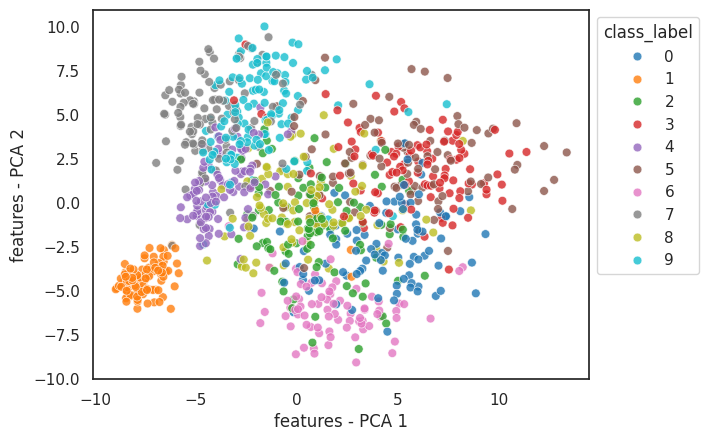

In [92]:
sns.set_theme(style="white")
#ax = sns.scatterplot(data=sample, x='features - PCA 1', y='features - PCA 2', hue='class label', alpha=alpha, marker=style, s=markersize, palette=color_palette)
ax = sns.scatterplot(data=sample, x='features - PCA 1', y='features - PCA 2', hue='class_label', alpha=alpha, marker=style, s=markersize, palette=color_palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

We can compare this to the first and second PCA dimensions of the image embeddings.

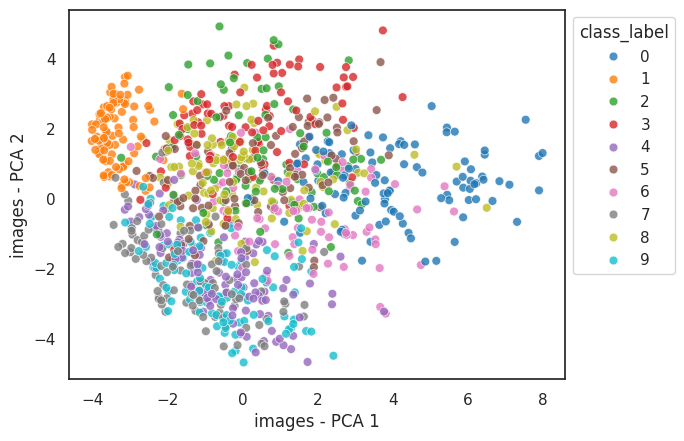

In [95]:
sns.set_theme(style="white")
ax = sns.scatterplot(data=sample, x='images - PCA 1', y='images - PCA 2', hue='class_label', alpha=alpha, marker=style, s=markersize, palette=color_palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

We can do similar for the third and fourth PCA dimension. Feel free to try it out.

But let us now plot the t-SNE dimensions, first for the feature embeddings.

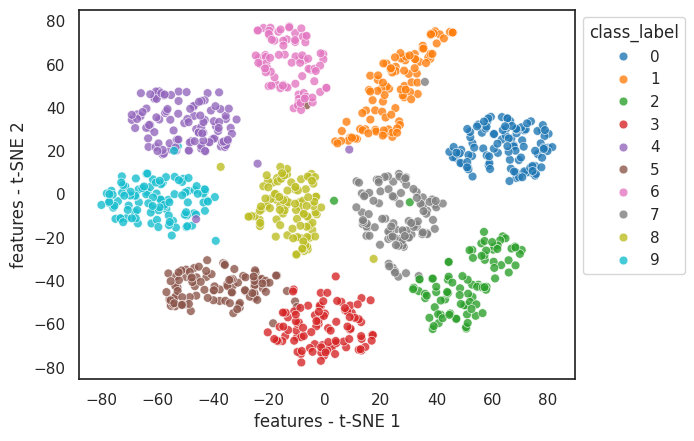

In [97]:
sns.set_theme(style="white")
ax = sns.scatterplot(data=sample, x='features - t-SNE 1', y='features - t-SNE 2', hue='class_label', alpha=alpha, marker=style, s=markersize, palette=color_palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

And now let's compare this with the t-SNE dimensions of the image embeddings.

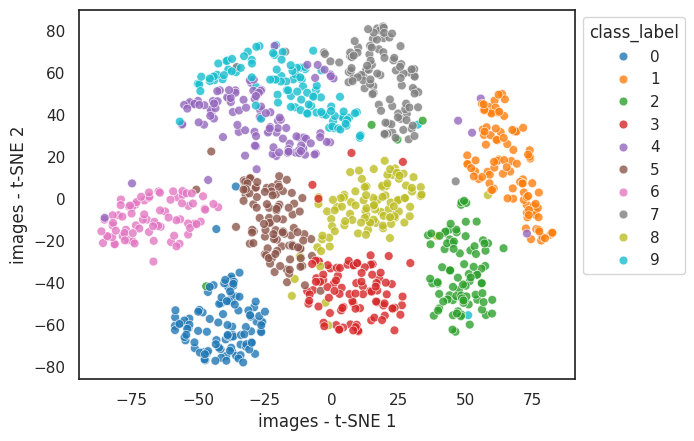

In [98]:
sns.set_theme(style="white")
ax = sns.scatterplot(data=sample, x='images - t-SNE 1', y='images - t-SNE 2', hue='class_label', alpha=alpha, marker=style, s=markersize, palette=color_palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

We observe that the learned feature embeddings yield a better and more consistent separation of digit classes compared to the image embeddings. However, we can see that even the image embeddings nicely separate the digit classes. This is not too suprising, given that we obtained high accuracy for MNIST digit classification with a simple linear model (the logistic regression-like model implemented as a single-layer network). This will be very different for more difficult image classification tasks where the class separation will be less clear.

## Interactive visualisation

The following visualisation allows you to interact with the scatter plot and display the corresponding images. This is a great way to better understand failure cases. Look out for images that are located in the wrong digit cluster.

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from matplotlib import cm
from ipywidgets import Output, HBox

In [100]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[label]) for label in sample.class_label.values]

In [101]:
x = 'features - t-SNE 1'
y = 'features - t-SNE 2'

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    idx = sample.index.values[points.point_inds[0]]
    img = images[idx, :]
    
    s = [8] * len(sample)
    for i in points.point_inds:
        s[i] = 16
    with fig.batch_update():
        scatter.marker.size = s

    f, ax = plt.subplots(1,1, figsize=(4,4))
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.axis('off')
    plt.show(f)
    
fig = go.FigureWidget(px.scatter(sample, x=x, y=y, template='plotly_white', hover_data={'class_label': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [8] * len(sample)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': array([[8],
                                   [3],
…

## Now it's your turn

**Task:** Perform a similar model inspection for one of the chest X-ray classification models from the coursework.